# Data Mining Pilot Study and Plan

## 1.1 Background

The New York Times is one of the world’s most circulated newspapers with a history dating back to 1851. A lot has changed in society during the 150 plus year history of The Times, but few things have gained as much attention as the portrayal of women in media. Ever since the recent gender equality discussion (Carlsen, A., Salam, M., Miller, C.C., Lu, D. Ngu, A. Patel, J.K., & Wichter, Z., 2018) change seems to have sped up. It's become increasingly important for newspapers to be mindful of the way they represent women, in order to stay relevant and, perhaps most importantly, not suffer backlash resulting in damage to their image and credibility.

## 1.2 Problem description

With the recent surge in coverage of media and its treatment of women, the New York Times is interested in looking at the optics of their own publications as it relates to gender. Looking back through history, they are interested in their difference in coverage of male and female subjects, as well as how this relates to the gender of the author.

Our first question pertains to the representation of women subjects in articles and other news items. According to Collins, Rebecca L. (Sex Roles; New York Vol. 64, Iss. 3-4) women are under-represented across a range of media and settings, including newspapers. Secondly when they are portrayed it is often in a negative manner. We want to research how the representation of women, in articles published by New York Times, has changed over the last 150 years. By doing so we can help NYT understand where they stand right now as it relates to gender representation, and how they have progressed over the years.

Our second inquiry relates to how journalists affect the content and coverage that they deliver. According to a study by Armstrong, “the gender of the newswriter can be linked to gender portrayals within news stories.” (Armstrong, C.L., 2008) It suggests that the gender of selected sources and individuals that get covered is related to that of the journalist. Looking at NYT’s publications, we will examine if such a correlation can be found and how this might affect hiring decisions in the future.


## 1.3 Hypothesis

In our pilot study we set out to answer the following three hypotheses. They are all interesting for New York Times as it's a clear indicator of how gender-biased there news reporting and writting is.

* Female pronouns will be under-representated in the articles compared to male pronouns.
* Female pronouns will be higher representated in more negative articles
* The representation of female and male pronouns will differ for different news categories

## 2.1 Data Collection and Preprocessing

The NYT dataset consists of all published newspapers from September 1851 until the most recent month. Due to the constraints of the Jupyter Notebook’s working memory, we had to limit ourselves somewhat in which data we included in our pilot study, and as such we chose the range of 1965-2017. Since the NYT Archive API can only deliver data in the form of all articles published in a specific year and month, we additionally decided to make a selection of three specific months – XYZ, ABC, and September – from each year in the range. Our hope is that by choosing quite widely spread months, we will limit the impact of special events or catastrophes, which would otherwise be likely to impact the reporting noticeably.


The API data includes a number of distinct attributes: headlines, lead paragraphs and metadata such as type of article, date of publication, writer, subject category and so on. The text data received from the NYT API is generally free from spelling and grammatical errors, due to the nature of the journalistic content (typically reviewed and well corrected). The relatively low amount of spelling and/or grammatical errors resulted in our decision to not look for, or clean the data of such errors.


### 2.1.1 API-key
To gather data from the New York Times API you need to sign up for an API-key which is free to do at developer.nytimes.com. The API offers some different services who all require different keys, this pilot study will only utilise the Archive Search service. We have included a file containing all the necessesary data that can be run locally instead of requesting the data from the API. If new data is to be collected from the API an API-key have to be providedto complete the request. In the section below an API-key can be added.

In [1]:
# NYTimes Archive Service API-key
api_key = "c86bad0043d3407ebc5869abd10dade4"

### 2.1.2 Requirements

All the required packages are specified in the requirements.txt file. For the sentiment analysis to work the user has to have the vader_lexicon downloaded, uncomment the last line in this section to download it.

In [41]:
!pip install -r requirements.txt

import pandas as pd
import numpy as np
import json
import warnings
import time
import requests

warnings.simplefilter(action='ignore', category=FutureWarning)
from urllib.request import urlopen
import re
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

# the following two lines set up our visualization settings
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = [10, 6]
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
import seaborn as sns

import time

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Uncomment to download vader lexicon again for sentiment analysis
#nltk.download('vader_lexicon')


### 2.1.3 Load files locally

Instead of requesting the data from the New York Times API we can collect everything from a local saved file. It's important that the file is formatted correctly to work with the data preprocessing

In [45]:
# Change this value to false if making a new request to the API
load_papers_locally = False

# Only gather data from our selected time period 1965-2017.
year_span = range(1965,2017,1)

print(year_span)

# All the gathered years in a list
year = []
for number in year_span:
    year.append(number)

# If the data should be loaded from a local file
if(load_papers_locally):
    nyt_papers = joblib.load("nyt_papers_lead_paragraph_range(1965, 2017).pkl")

range(1965, 2017)


### 2.1.4 Data Collection 

Collects papers from March, June and September for the years 1965-2017.

For the purpose of this initial pilot study, we decided to select the lead paragraphs from the articles as the main basis for the analysis. This was done in order to limit the size of the data and improve fetching and processing time, while still keeping the most critical data from the data set. We are performing statistical sentiment analysis on the data through the Natural Language Toolkit, and corpus-trained algorithms are known to decrease in accuracy with the size of the data. (Cambria, E. 2016) Therefore it was important to try to achieve the longest text length possible which proved to be the lead paragraph. 

In [4]:
# Check if papers are gathered from saved file instead
if(load_papers_locally != True):
    nyt_papers = []

    collection_number = 1
    for year in year_span:
        # Get three samples for each year containing all the articles for the three different months.

        # SAMPLE 1
        sample1Json = pd.read_json("http://api.nytimes.com/svc/archive/v1/" + str(year) + "/3.json?api-key=" + api_key)
        sample1 = pd.DataFrame(sample1Json.response.docs, columns=['section_name', 'lead_paragraph'])
                
        # SAMPLE 2
        sample2Json = pd.read_json("http://api.nytimes.com/svc/archive/v1/" + str(year) + "/6.json?api-key=" + api_key)
        sample2 = pd.DataFrame(sample2Json.response.docs, columns=['section_name', 'lead_paragraph'])
        sample1.append(sample2)

        # SAMPLE 3
        sample3Json = pd.read_json("http://api.nytimes.com/svc/archive/v1/" + str(year) + "/9.json?api-key=" + api_key)
        sample3 = pd.DataFrame(sample3Json.response.docs, columns=['section_name', 'lead_paragraph'])
        sample1.append(sample3)
        
        # Append all three samples to one collection
        nyt_papers.append(sample1)

        # Loading message
        print(str(collection_number) + "/" + str(len(year_span)) + " collections loaded")
        collection_number = collection_number + 1

    # Used to gather multiple collections (1 collection = 1 year worth of news papers)

## 3.1 Preliminary Data Analysis

Our primary data mining analysis tool is classification. First, we searched the data for occurences of male and female pronouns. Male pronouns chosen were "Mr., He, His, Himself", while female pronouns were "Ms., Mrs., She, Herself, Her, Hers". We then proceeded to classify the percentage of the lead paragraph being of each gender pronoun. Next, we used the Natural Language Toolkit (www.nltk.org) to perform a sentiment analysis on these two datasets, giving them positive, neutral and negative scores. The scoring from the sentiment analysis ranges from -1 to +1, where -1 is negative and +1 positive, scores around 0 are considered neutral. Lastly we added an attribute for the percentage difference between male and female pronouns for each year of articles.

The following code cell retrieves all the information we are interested in, e.g. female and male pronoun count, female and male pronoun percentage, attitude, and difference in pronouns. All the processed data is saved in the "result" DataFrame.

In [142]:
# Save all the results and results for each category in this dataframe
result = pd.DataFrame({
    # All = Data for all the articles
    # male_pronoun_count = The totalt count of male pronouns for each collection
    # female_pronoun_count = The totalt count of female pronouns for each collection
    # male_pronoun_percentage = The percentage of pronouns that are considered male in the article
    # female_pronoun_percentage = The percentage of pronouns that are considered female in the article
    # word_count = The total amount of words in the collection
    # attitude = The compound value of the sentiment analysis. Ranging from: -1 negative, 0 neutral and +1 positive
    # difference_prounouns = The difference between male and female pronouns, holding the percentage of ...
    # ... pronouns in the article that are female. (female_pronouns / all_pronouns)
    'All': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }, 
    # Sports = Data for all the articles with the category sports
    'Sports': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }, 
    # Opinion = Data for all the articles with the category opinion
    'Opinion': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }, 
    # Business = Data for all the articles with the category business
    'Business': {
        'male_pronoun_count': [],
        'female_pronoun_count': [],
        'male_pronoun_percentage': [],
        'female_pronoun_percentage': [],
        'word_count': [],
        'attitude': [],
        'difference_pronouns': []
    }
})

# Female pronouns to match with the article content
female_pronouns = ["Ms.", "Mrs.", " she ", "She ", "Herself", "herself", "Her ", " her ", "Hers ", " hers "]

# Male pronouns to match with the article content
male_pronouns = ["Mr.", " he ", "He ", "His ", " his ", "Himself", "himself"]

# Count all the words, female and male pronouns in the collection (1 year of papers)
collection_word_count = 0
collection_female_pronoun_count = 0
collection_male_pronoun_count = 0

# Count the processed articles
articles_count = 0


# For sentiment analysis
sid = SentimentIntensityAnalyzer()
i = 0

# Loop through all collections (years) in the stored papers.
for collection in nyt_papers:
    i = i + 1
    
    # Save all compound values per collection in this list
    all_compound_values_list = []
    
    # Create a object to hold all the different category data per collection
    categories = {
        'Sports': {
            'male_pronoun_count': 0,
            'female_pronoun_count': 0,
            'word_count': 0,
            'attitude': []
        }, 
        'Opinion': {
            'male_pronoun_count': 0,
            'female_pronoun_count': 0,
            'word_count': 0,
            'attitude': []        
        }, 
        'Business': {
            'male_pronoun_count': 0,
            'female_pronoun_count': 0,
            'word_count': 0,
            'attitude': []
        }
    }
    
    # Loop through all the rows in the collection
    for index, row in collection.iterrows():
        article = row.lead_paragraph
        
        # Only process if the article has a lead paragraph
        if(article is not None):
            # Set the articles sentiment score (ss = sentiment score)
            ss = sid.polarity_scores(article)

            # Count the female pronouns for every article in the collection 
            article_female_pronoun_count = 0

            # Count all the female pronouns
            for pronoun in female_pronouns:
                article_female_pronoun_count += np.char.count(str(article), pronoun)
            collection_female_pronoun_count += article_female_pronoun_count

            # Count the female pronouns for every article in the collection 
            article_male_pronoun_count = 0
            
            # Count all the male pronouns
            for pronoun in male_pronouns:
                article_male_pronoun_count = article_male_pronoun_count + np.char.count(str(article), pronoun)
            collection_male_pronoun_count = collection_male_pronoun_count + article_male_pronoun_count
            
            # Add the articles compound sentiment score to the collections totalt score
            all_compound_values_list.append(ss['compound'])
            
            # Calculate the percentage of male and female pronouns in the article
            article_male_pronoun_percentage = article_male_pronoun_count / len(str(article).split())
            article_female_pronoun_percentage = article_female_pronoun_count / len(str(article).split())
            
            # Keep the count for all words in the collection
            collection_word_count += len(str(article).split())

            # For each category defined by us (Business, Opinion, Sports)
            for category in categories:
                # If the article has a category
                if row.section_name is None:
                    continue
                
                # If the articles category matches our defined categories
                if category in row.section_name:
                    # Save the data to the corresponding category
                    categories[category]['male_pronoun_count'] += article_male_pronoun_count
                    categories[category]['female_pronoun_count'] += article_female_pronoun_count
                    categories[category]['word_count'] += len(str(article).split())
                    categories[category]['attitude'].append(ss['compound'])
            
            # Increase the article counter after the article have been processed
            articles_count = articles_count + 1
    
    # Save the average result for each attribute after all articles in the collection have been processed
    result['All']['male_pronoun_count'].append(collection_male_pronoun_count)
    result['All']['female_pronoun_count'].append(collection_female_pronoun_count)
    result['All']['male_pronoun_percentage'].append((collection_male_pronoun_count / collection_word_count) * 100)
    result['All']['female_pronoun_percentage'].append((collection_female_pronoun_count / collection_word_count) * 100)
    result['All']['word_count'].append(collection_word_count)
    result['All']['attitude'].append(sum(all_compound_values_list)/len(all_compound_values_list))
    result['All']['difference_pronouns'].append(collection_female_pronoun_count / (collection_female_pronoun_count + collection_male_pronoun_count))
    
    # print(categories[category]['word_count'])
    
    # Save the average result for each category for each attribute after 
    # all articles in the collection have been processed
    if categories[category]['word_count'] != 0:
        for category in categories:
            result[category]['male_pronoun_count'].append(categories[category]['male_pronoun_count'])
            result[category]['female_pronoun_count'].append(categories[category]['female_pronoun_count'])
            result[category]['male_pronoun_percentage'].append((categories[category]['male_pronoun_count'] / categories[category]['word_count']) * 100)
            result[category]['female_pronoun_percentage'].append((categories[category]['female_pronoun_count'] / categories[category]['word_count']) * 100)
            result[category]['word_count'].append(categories[category]['word_count'])
            result[category]['attitude'].append(sum(categories[category]['attitude']) / len(categories[category]['attitude']))
            result[category]['difference_pronouns'].append(categories[category]['female_pronoun_count'] / (categories[category]['female_pronoun_count'] + categories[category]['male_pronoun_count']))
    
    # Reset the collection counters before processing next collection
    collection_female_pronoun_count = 0
    collection_male_pronoun_count = 0
    collection_word_count = 0
    
    # Print progress
    print(str(i) + "/" + str(len(year_span)) + " collections processed")


1/52 collections processed
2/52 collections processed
3/52 collections processed
4/52 collections processed
5/52 collections processed
6/52 collections processed
7/52 collections processed
8/52 collections processed
9/52 collections processed
10/52 collections processed
11/52 collections processed
12/52 collections processed
13/52 collections processed
14/52 collections processed
15/52 collections processed
16/52 collections processed
17/52 collections processed
18/52 collections processed
19/52 collections processed
20/52 collections processed
21/52 collections processed
22/52 collections processed
23/52 collections processed
24/52 collections processed
25/52 collections processed
26/52 collections processed
27/52 collections processed
28/52 collections processed
29/52 collections processed
30/52 collections processed
31/52 collections processed
32/52 collections processed
33/52 collections processed
34/52 collections processed
35/52 collections processed
36/52 collections processed
3

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in long_scalars


44/52 collections processed
45/52 collections processed
46/52 collections processed
47/52 collections processed
48/52 collections processed
49/52 collections processed
50/52 collections processed
51/52 collections processed
52/52 collections processed


## 4.1 Data collections in tables

### 4.1.1 Table showing number of pronouns and percentage for each year

Table showing the data for all the years and attributes. This is all the data we will work with and analyse in the coming sections.

The difference shown in the tables below is the percentage of pronouns being female. Calculated by female_pronouns / (female_pronouns + male_pronouns). For example: the number 0.25 would represent that the there is 4 times more male pronouns compared to female.

In [46]:
# Print all the results in a table
df = pd.DataFrame({
    "Male": result['All']['male_pronoun_count'],
    "Male Percentage": result['All']['male_pronoun_percentage'], 
    "Female": result['All']['female_pronoun_count'],
    "Female Percentage": result['All']['female_pronoun_percentage'],
    "Attitude": result['All']['attitude'],
    "Difference": result['All']['difference_pronouns']
}, index=year)
df


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1965,1309,0.606232,385,0.178303,0.131038,0.227273
1966,2281,0.951082,1051,0.438223,0.098950,0.315426
1967,2408,0.994519,1119,0.462154,0.080376,0.317267
1968,1420,0.726551,265,0.135589,0.084999,0.157270
1969,1697,0.774815,358,0.163455,0.084921,0.174209
1970,1937,0.826728,718,0.306449,0.063430,0.270433
1971,1438,0.701313,390,0.190203,0.081653,0.213348
1972,1709,0.776659,473,0.214956,0.094545,0.216774
1973,2382,0.940001,804,0.317280,0.036276,0.252354
1974,2628,0.973175,952,0.352535,0.053391,0.265922


### 4.1.2 Table showing number of pronouns and percentage for each year and category
Showing all the data for the categories: Sports, Business and Opinion

In [47]:
# Print the result for each category in seperate tables
for category in categories:
    df = pd.DataFrame({
        "Male": result[category]['male_pronoun_count'], 
        "Male Percentage": result[category]['male_pronoun_percentage'],
        "Female": result[category]['female_pronoun_count'],
        "Female Percentage": result[category]['female_pronoun_percentage'],
        "Attitude": result[category]['attitude'],
        "Difference": result[category]['difference_pronouns']
    }, index=range(1981, 2017))
    
    print(category + ":")
    display(df)
    print("")


Sports:


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1981,1034,1.620817,84,0.131672,0.285635,0.075134
1982,1027,1.407871,103,0.141198,0.226555,0.091150
1983,1136,1.387667,139,0.169794,0.260548,0.109020
1984,1172,1.586142,129,0.174584,0.235747,0.099154
1985,1174,1.476655,138,0.173576,0.211637,0.105183
1986,1324,1.544636,112,0.130664,0.234953,0.077994
1987,623,1.603315,37,0.095221,0.146566,0.056061
1988,475,1.412976,54,0.160633,0.099922,0.102079
1989,557,1.691775,39,0.118455,0.103341,0.065436
1990,360,1.139313,46,0.145579,0.091351,0.113300



Opinion:


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1981,497,0.919026,86,0.159027,0.115533,0.147513
1982,462,1.026941,53,0.117809,0.070263,0.102913
1983,383,0.832645,84,0.182617,0.025266,0.179872
1984,510,1.043884,98,0.200589,0.037171,0.161184
1985,471,0.949846,72,0.145199,0.053112,0.132597
1986,551,1.057338,83,0.159272,0.048950,0.130915
1987,233,1.197759,45,0.231327,0.032392,0.161871
1988,106,0.617932,50,0.291477,0.053205,0.320513
1989,219,1.207943,29,0.159956,0.050580,0.116935
1990,135,0.797307,27,0.159461,0.042136,0.166667



Business:


,Male,Male Percentage,Female,Female Percentage,Attitude,Difference
1981,638,0.659663,49,0.050664,0.315938,0.071325
1982,567,0.657247,32,0.037093,0.212730,0.053422
1983,546,0.600112,21,0.023081,0.249016,0.037037
1984,639,0.676477,25,0.026466,0.291001,0.037651
1985,859,0.901705,45,0.047237,0.227250,0.049779
1986,721,0.767062,20,0.021278,0.272433,0.026991
1987,180,0.218177,14,0.016969,0.236821,0.072165
1988,192,0.200942,28,0.029304,0.208419,0.127273
1989,205,0.193745,9,0.008506,0.227323,0.042056
1990,232,0.213128,10,0.009187,0.243670,0.041322


## 5. Visualisation

### 5.1 Male & Female pronouns

#### 5.1.1 Pie charts displaying the total male/female pronoun ratio

All:


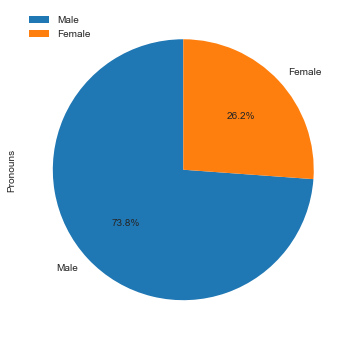

Sports:


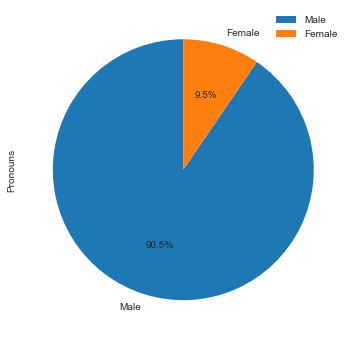

Opinion:


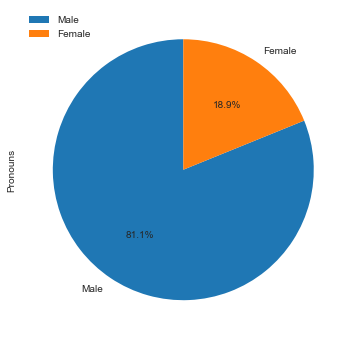

Business:


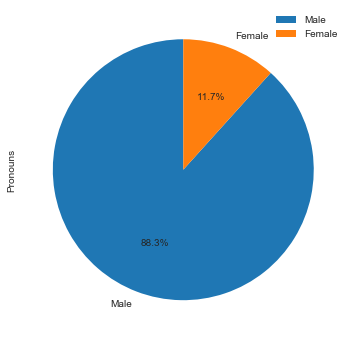

In [48]:
# Show pie chart for all the articles
df = pd.DataFrame({
'label': ["Male", "Female"],
'Pronouns': [
    pd.Series(result['All']['male_pronoun_count']).sum(), 
    pd.Series(result['All']['female_pronoun_count']).sum()
],
'total': pd.Series(result['All']['word_count']).sum()
}, 
columns=['label', 'Pronouns', 'total'])

print("All:")
df.plot(kind='pie', y='Pronouns', autopct='%1.1f%%', startangle=90, labels=df['label'])

# Show pie chart for each category
for category in categories:
    df = pd.DataFrame({
    'label': ["Male", "Female"],
    'Pronouns': [pd.Series(result[category]['male_pronoun_count']).sum(), pd.Series(result[category]['female_pronoun_count']).sum()],
    'total': pd.Series(result[category]['word_count']).sum()
    }, 
    columns=['label', 'Pronouns', 'total'])
    
    plt.show()
    print(category + ":")
    df.plot(kind='pie', y='Pronouns', autopct='%1.1f%%', startangle=90, labels=df['label'])



#### 5.1.2 Graph showing percentage of pronouns for respective gender

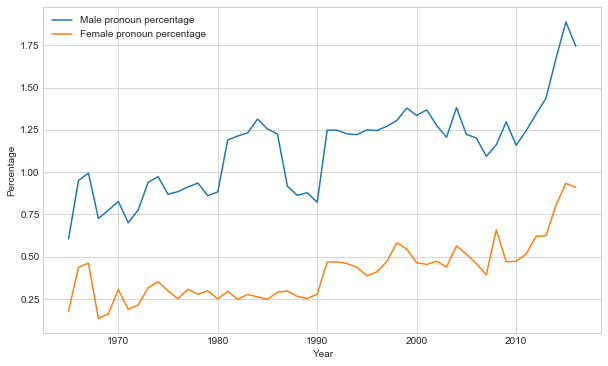

In [143]:
df = pd.DataFrame({
    'Year': year, 
    "Male pronoun percentage": result['All']['male_pronoun_percentage'], 
    "Female pronoun percentage": result['All']['female_pronoun_percentage']
})

df.plot(x='Year')
plt.xlabel("Year")
plt.ylabel("Percentage")


plt.xlabel("Year")
plt.ylabel("Percentage")
plt.grid(b=True, which ='minor',axis='both')
# plt.xticks(np.arange(1965, 2017, step=1),  fontsize=10, rotation=-90)
# Graph showing number of pronouns found for respective gender

#### 5.1.3 Graphs showing percentage of pronouns for respective gender and category

Sports:


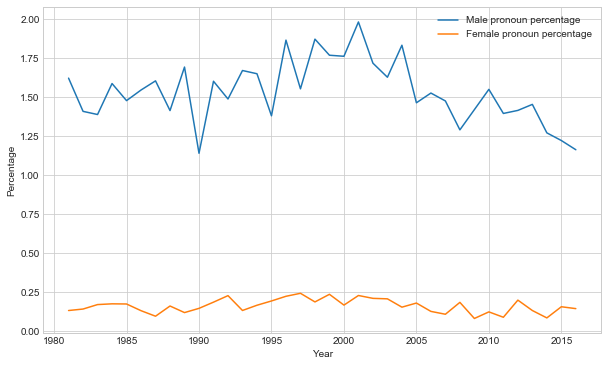

Opinion:


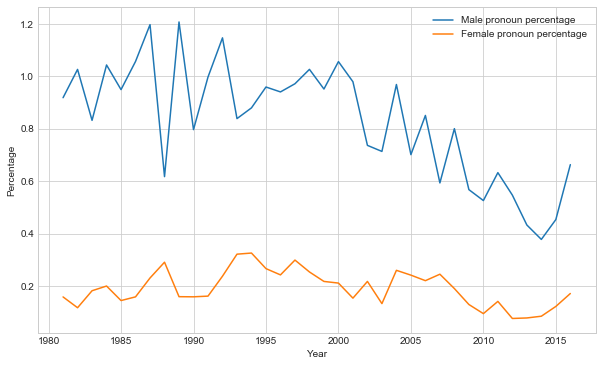

Business:


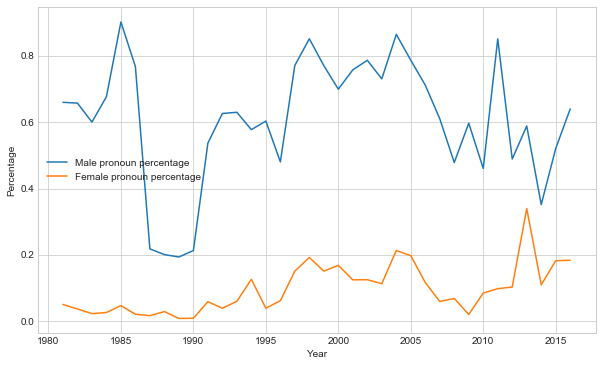

In [132]:
for category in categories:
    print(category + ":")

    df = pd.DataFrame({
        'Year': range(1981, 2017), 
        "Male pronoun percentage": result[category]['male_pronoun_percentage'], 
        "Female pronoun percentage": result[category]['female_pronoun_percentage']
    })
    
    df.plot(x='Year')
    plt.xlabel("Year")
    plt.ylabel("Percentage")
    plt.show()

# Graph showing number of pronouns found for respective gender

#### 5.1.4 Graph showing number of pronouns found for respective gender

Text(0, 0.5, 'Pronoun count')

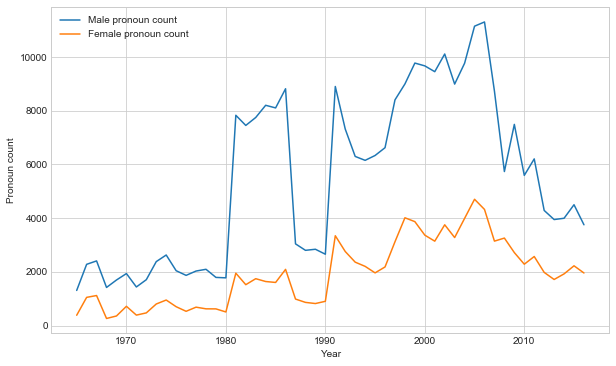

In [126]:
year = []
for number in year_span:
    year.append(number)

df = pd.DataFrame({
    'Year': year, 
    "Male pronoun count": result['All']['male_pronoun_count'], 
    "Female pronoun count": result['All']['female_pronoun_count']
})

df.plot(x='Year')
plt.xlabel("Year")
plt.ylabel("Pronoun count")

# Graph showing number of pronouns found for respective gender

### 5.2 Attitudes

#### 5.2.1 Graphs showing average attitude over the years

Text(0, 0.5, 'Attitude')

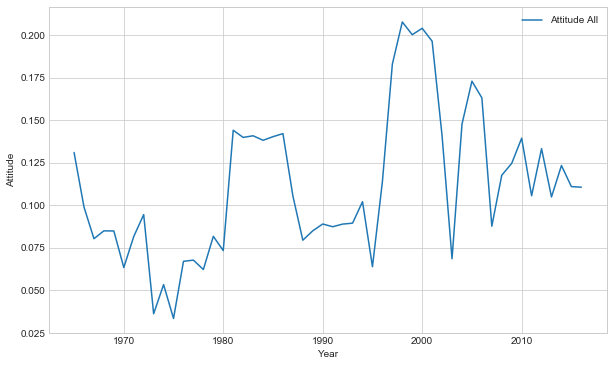

In [119]:
df = pd.DataFrame({'year': year, 'Attitude All': result['All']['attitude']})
df.plot(x='year')

plt.xlabel("Year")
plt.ylabel("Attitude")

# Graph showing average attitude for all articlces

Text(0, 0.5, 'Attitude')

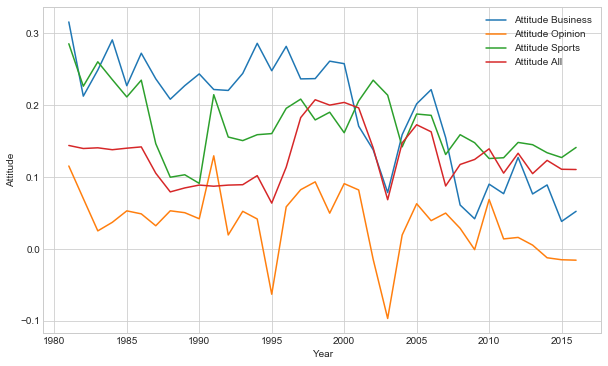

In [113]:
df = pd.DataFrame({'Year': year, 'Attitude All': result['All']['attitude']})

for category in categories:
    catDF = pd.DataFrame({'Year': range(1981,2017), 'Attitude ' + category: result[category]['attitude']})
    df = pd.merge(catDF, df, on='Year')
                  
df.plot(x='Year')
plt.xlabel("Year")
plt.ylabel("Attitude")

# Graph showing average attitude for the different categories

### 5.3 Attitude and Female & Male pronouns

#### 5.3.1 Table showing the pearson correlation between Attitude and Female & Male percentage

In [55]:
# Display tables showing the correlations between attitude and percentage of female and male pronouns
df = pd.DataFrame({
    "Female percentage": result["All"]["female_pronoun_percentage"], 
    "Male percentage": result["All"]["male_pronoun_percentage"], 
    "Attitude": result["All"]["attitude"]
})
frame = pd.DataFrame(df, columns=['Female percentage', 'Male percentage', 'Attitude'])
focus_cols = ['Attitude']
display(frame.corr().filter(focus_cols).drop(focus_cols))


for category in categories:
    df = pd.DataFrame({
        "Female percentage": result[category]["female_pronoun_percentage"], 
        "Male percentage": result[category]["male_pronoun_percentage"], 
        "Attitude": result[category]["attitude"]
    })
    frame = pd.DataFrame(df, columns=['Female percentage', 'Male percentage', 'Attitude'])
    focus_cols = ['Attitude']
    
    print("-------------------------")
    print("")
    print("")
    print(category + ":")
    display(frame.corr().filter(focus_cols).drop(focus_cols))




,Attitude
Female percentage,0.320300
Male percentage,0.500954


-------------------------


Sports:


,Attitude
Female percentage,0.382152
Male percentage,0.332858


-------------------------


Opinion:


,Attitude
Female percentage,0.177765
Male percentage,0.401494


-------------------------


Business:


,Attitude
Female percentage,-0.356506
Male percentage,0.034284


#### 5.3.2 Plots female and male percentage and the collection attitude



All:


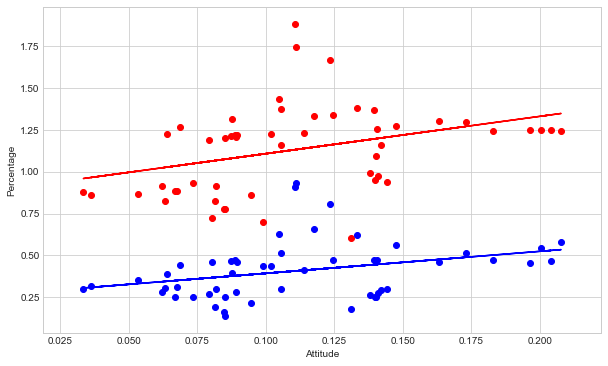

Sports:


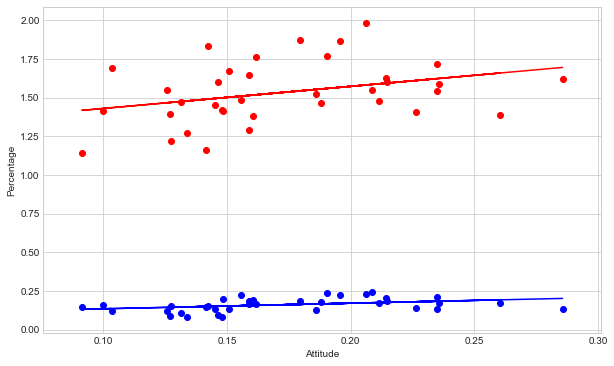

Opinion:


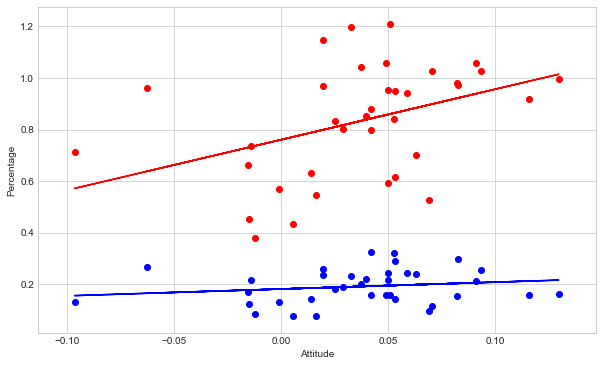

<Figure size 720x432 with 0 Axes>

Business:


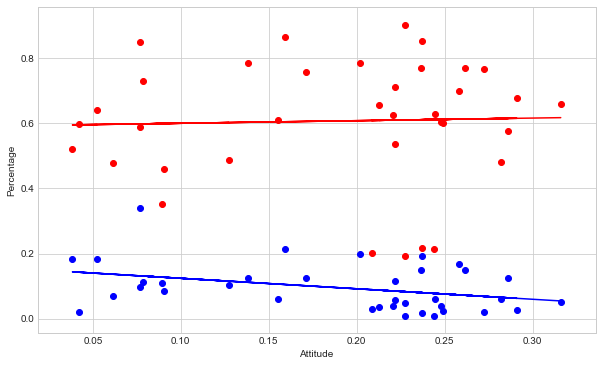

<Figure size 720x432 with 0 Axes>

In [128]:
print("All:")

lm_male = linear_model.LinearRegression()
lm_male.fit([[x] for x in result['All']['attitude']], result['All']['male_pronoun_percentage'])
m = lm_male.coef_[0]
b = lm_male.intercept_


plt.scatter(x=result['All']['attitude'], y=result['All']['male_pronoun_percentage'], c='red')
predicted_values_m = [lm_male.coef_ * i + lm_male.intercept_ for i in result['All']['attitude']]
plt.plot(result['All']['attitude'], predicted_values_m, 'red')


lm_female = linear_model.LinearRegression()
lm_female.fit([[x] for x in result['All']['attitude']], result['All']['female_pronoun_percentage'])
m = lm_female.coef_[0]
b = lm_female.intercept_

plt.scatter(x=result['All']['attitude'], y=result['All']['female_pronoun_percentage'], c='blue')
predicted_values_m = [lm_female.coef_ * i + lm_female.intercept_ for i in result['All']['attitude']]
plt.plot(result['All']['attitude'], predicted_values_m, 'blue')

plt.ylabel("Percentage")
plt.xlabel("Attitude")
plt.show()



i = 0
for category in categories:
    i += 1
    lm_male = linear_model.LinearRegression()
    lm_male.fit([[x] for x in result[category]['attitude']], result[category]['male_pronoun_percentage'])
    m = lm_male.coef_[0]
    b = lm_male.intercept_


    plt.scatter(x=result[category]['attitude'], y=result[category]['male_pronoun_percentage'], c='red')
    predicted_values_m = [lm_male.coef_ * i + lm_male.intercept_ for i in result[category]['attitude']]
    plt.plot(result[category]['attitude'], predicted_values_m, 'red')


    lm_female = linear_model.LinearRegression()
    lm_female.fit([[x] for x in result[category]['attitude']], result[category]['female_pronoun_percentage'])
    m = lm_female.coef_[0]
    b = lm_female.intercept_

    plt.scatter(x=result[category]['attitude'], y=result[category]['female_pronoun_percentage'], c='blue')
    predicted_values_m = [lm_female.coef_ * i + lm_female.intercept_ for i in result[category]['attitude']]
    plt.plot(result[category]['attitude'], predicted_values_m, 'blue')

    plt.ylabel("Percentage")
    plt.xlabel("Attitude")
    print(category + ":")    
    plt.figure(i)
    plt.show()


#### 5.4 Saving files

In [58]:
joblib.dump(nyt_papers, "nyt_papers_lead_paragraph_" + str(year_span) + ".pkl")

['nyt_papers_lead_paragraph_range(1965, 2017).pkl']

## 6. Preliminary Data Analysis

Our primary data mining analysis tool is classification. First, we searched the data for occurences of male and female pronouns. Male pronouns chosen were "Mr., He, His, Himself", while female pronouns were "Ms., Mrs., She, Herself, Her, Hers". We then proceeded to classify the percentage of the lead paragraph being of each gender pronoun. Next, we used the Natural Language Toolkit (www.nltk.org) to perform a sentiment analysis on these two datasets, giving them positive, neutral and negative scores. The scoring from the sentiment analysis ranges from -1 to +1, where -1 is negative and +1 positive, scores around 0 are considered neutral. Lastly we added an attribute for the percentage difference between male and female pronouns for each year of articles.

## 7. Evaluation of results

#### 7.1 Pie Charts
In the first section ([PIE CHARTS]) of our analysis, we looked at the count of male and female articles in the lead paragraphs. As can be seen in pie charts above, there is a clear difference in female and male representation in the New York Times articles we examine. The number of total female pronouns equates to little more than a fourth of the male pronoun count (26.2%). This difference is even more pronounced in certain subcategories of articles, such as Sports (9.5% female), Opinion (18.9% female, and Business (11.7% female). The reasons behind these differences in representation are of course unknown to us. However, due to the size of the differences, we can with certainty say that there is a pattern. Males are almost four times as likely to be mentioned in a news article published by NYT under the years 1965-2017.


#### 7.2 Line charts, pronouns over time
When watching the changes over time we can clearly see how the frequency in use of male pronounce fluctuates while it remains fairly steady amongst the female pronounces. Even so the same general trends can be mirrored in both lines in the graph for all articles (with the exception for the years 1980-1990) where the use of pronounces have clearly increased for both genders since 1990. Although when looking at the different categories the lines the same observed pattern isn’t present.

#### 7.3 Table on Pearson correlations
The Pearson correlation numbers show the relation between the amount of words being a female or male pronoun and the attitude of the collection. Most numbers in the table are positive meaning that there’s a positive correlation between the pronoun percentage and the attitude. There’s one instance of a negative correlation for female pronoun percentage in the business category.

#### 7.4 Scatter plots on attitude 
The scatter plots are a good visualisation of the numbers we could see in the Pearson correlation tables in the previous section saying that there’s a correlation between the pronoun percentages and the attitude of the collection. As we can see in the graph the higher number of pronoun percentage in the article the more positive attitude. This pattern can be seen in most categories with various strength except for female pronouns in the business category. There we have a negative correlation meaning that a higher percentage of female pronouns will lead to a less positive attitude. The strongest correlation can be seen in the opinion category for male pronouns where the increase of pronouns have a large positive effect on the attitude. 


## 8. Schedule and description of project plan

Rough schedule for the project beyond the pilot study presented in 3-5. This does not have to be advanced, you can simply provide an estimate based upon reported schedules for similar projects in the literature.

For a more accurate and reliable conclusion, an analysis of the complete dataset, rather than the current sample set, should be carried out (the sample set consist of ¼ of articles between 1965 and 2017, which is a subset of the entire set, which consist of all articles between 1851 and 2017). This would ideally also include the time consuming task of retrieving the full articles as linked in the data objects from the API followed by performing the analyses on this more complete corpus of data (currently, only the lead paragraphs and some meta data is used). The gender of the author of each article could also be taken into account, to examine whether there is a correlation between gender of the author and gender of the subjects in the articles. This categorization would, however, require us to categorize names as female or male, which would open up new set of potential problems. 

A future development of this project could include comparisons to similar research. In particular the work by Twenge et al. from 2012, which examines the representation of the different genders in American books 1900 to 2008, would be a good fit for comparison.

Taking the project further a comparison with a dataset containing more opinionated data from the average person, like Twitter, would be of interest with its contrast to the New York Times articles, which in its nature try to stay as neutral as possible. Could more distinct patterns be found amongst the unfiltered voiced opinion of the public? Could the outcome if so further confirm the currently reached conclusion that New York Times has managed to maintain its objectivity through the years? 


## 9. Ethical aspects that need to be considered

Danah Boyd and Kate Crawford discuss some ethical questions in their work from 2012. Among the different topics in the paper, an important one, we think, is found under chapter 3. The meaning behind the quote "Just because Big Data presents us with large quantities of data does not mean that methodological issues are no longer relevant" have some implications worth considering, in relation to this project. In the paper the authors discuss an example where research was done on twitter data, as a way of capturing mood swings in a population. The fact, the authors say, is that twitter data does not represent a population in any way. In contrary it is a fallacy to try and equate "all people" to "twitter users". Even simply assuming one twitter user represents one human, is a mistake - as many people have more than one twitter account (Danah Boyd, Kate Crawford, 2012). 

While this project, in its current form, does not base itself on any type of user created data and use that to interpolate a bigger meaning and thus avoids being subject to the same potential fallacies as discussed above in the twitter example, we still have to be mindful when selecting our sample data. The fact that this project uses ¼ of the papers from a given year, will likely have effects on the results and analysis. For this reason it is important that this project is viewed not as a complete study, but as pilot one - a proof of concept. 

Another important point from Danah Boyd and Kate Crawford make is: "Interpretation is at the center of data analysis. Regardless of the size of a data, it is subject to limitation and bias. Without those biases and limitations being understood and outlined, misinterpretation is the result".  The authors make this point because, they say, there is a tendency in fields such as social science to use Big Data as way to impose "hard science" on previously "softer" such, without being critical or mindful enough of potential biases. In this pilot study, extra care will have to be taken in order to minimize the effects of our biases. There is a risk we end up tuning and pruning the data until we find the results we expect.

Ethics in relation to the nature of news and implications of this study
Newspapers do have an obligation to report things that happen, rather than whatever fits a desired mold of society. Our findings are only meant to highlight potential bias that may be controlling which part of the world’s happenings get covered. As such, we are not suggesting that journalists under NYT employ should be attempting to remove all disparity in their reporting at the expense of truth. In fact, attempts to do so may even harm society; because of the news’ role as informant to the public, artificially inflating the frequency of actions of men or women may give people a skewed sense of the world. We only mean to encourage an awareness of perspectives that might get missed when reporting. Rather than news items being written with an unconscious limitation on sources and content, we would like these decisions to be made from an informed position and with intent.

If the full study goes ahead and involves perceived author gender, further issues could arise. We would strongly suggest anonymizing the data as much as possible by removing the name as soon as the gender has been determined. However, even after anonymizing the data, it is possible that the more recent results could have some fallout if revealed to the public, possibly even if the study is limited to the workforce. We would encourage being prepared 


## References

Armstrong, C. L. (2004) ‘The Influence of Reporter Gender on Source Selection in Newspaper Stories’, Journalism & Mass Communication Quarterly, 81(1), pp. 139–154. Available at: https://search-ebscohost-com.ezproxy.its.uu.se/login.aspx?direct=true&db=eue&AN=507903756&site=ehost-live  (Accessed on 13 November 2018).

Cambria, E. 2016, "Affective Computing and Sentiment Analysis", IEEE Intelligent Systems, vol. 31, no. 2, pp. 102-107. Available: https://ieeexplore.ieee.org/document/7435182 (Accessed on 2018-11-22)

Carlsen, A., Salam, M., Miller, C.C., Lu, D. Ngu, A. Patel, J.K., & Wichter, Z. (2018) ‘#MeToo Brought Down 201 Powerful Men. Nearly Half of Their Replacements Are Women.’ The New York Times, updated 19th Oct [Online]. Available: https://www.nytimes.com/interactive/2018/10/23/us/metoo-replacements.html (Accessed on 2018-11-12)

Collins, R. L. (2011). Content analysis of gender roles in media: Where are we now and where should we go? Sex Roles, 64(3-4), 290-298. doi:http://dx.doi.org.ezproxy.its.uu.se/10.1007/s11199-010-9929-5

Twenge, J.M., Campbell, W.K. & Gentile, B. Sex Roles (2012) 67: 488. https://doi-org.ezproxy.its.uu.se/10.1007/s11199-012-0194-7

Danah Boyd & Kate Crawford (2012) CRITICAL QUESTIONS FOR BIG DATA, Information, Communication & Society, 15:5,662-679, DOI: 10.1080/1369118X.2012.678878